## Librairies

In [ ]:
! pip install import-ipynb


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import import_ipynb
from data_preparation import Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, mean_squared_error
import optuna


import warnings
warnings.filterwarnings('ignore')

In [3]:
path = "../data/IPG2211A2N.csv"
d1 = Data(path)
df = d1.read_data()
X, y = d1.create_features(df ,'IPG2211A2N' )


In [4]:
def plot_forecasts(y_test, y_pred):
    plt.plot(y_test, label='True Values')
    plt.plot(y_pred, label='Predictions')
    plt.legend()
    return plt.show()

## Model selection

As mentioned in the previous notebook, we will add the previous 12 values as new columns. Since we are working with time series data, LSTM models are well-suited for this task.

#### 1- Stacked LSTM Model

In [5]:
X, y = d1.create_features(df ,'IPG2211A2N' )
# Split into training and testing sets
split_index = int(len(X) * 0.8)  # Use 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the datasets before reshaping for LSTM
print(f"X_train shape before reshape: {X_train.shape}, X_test shape before reshape: {X_test.shape}")

# Reshape input data for LSTM (3D shape: [samples, time_steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adding '1' as the number of features
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Check the shapes after reshaping
print(f"X_train shape after reshape: {X_train.shape}, X_test shape after reshape: {X_test.shape}")

X_train shape before reshape: (814, 12, 1), X_test shape before reshape: (204, 12, 1)
X_train shape after reshape: (814, 12, 1), X_test shape after reshape: (204, 12, 1)


In [31]:
def LSTM_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))  # Final LSTM layer
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=[RootMeanSquaredError()] )
    return model


To improve the model's ability to learn from data, cross-validation techniques are essential. Time Series Cross-Validation (TSCV) adapts traditional cross-validation methods to account for the temporal structure of time series data. Unlike standard cross-validation, which uses random splits, TSCV maintains the chronological order of observations. This approach ensures that the model is trained on past data and tested on future data, closely simulating real-world scenarios.


In [32]:
def cross_validation(model, n_splits, epochs, batch_size):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    split = 1
    # Initialize lists to store RMSE values
    train_rmse_history = []
    val_rmse_history = []
    for train_index, test_index in tscv.split(X):
        print(f"Split {split}:")
        split += 1
        # Split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Train the model with validation data
       
        history = model.fit(
            X_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=(X_test, y_test), 
            verbose=1
        )
        # Collect training and validation RMSE
        train_rmse = [np.sqrt(mse) for mse in history.history['loss']]
        val_rmse = [np.sqrt(mse) for mse in history.history['val_loss']]
        train_rmse_history.append(train_rmse)
        val_rmse_history.append(val_rmse)
        print("-" * 50)
    # Plot RMSE for all splits
    plt.figure(figsize=(12, 6))
    plt.plot(train_rmse_history[-1], label=f'Train Split {5}', linestyle='--')
    plt.plot(val_rmse_history[-1], label=f'Val Split {5}')
    plt.title('Training and Validation RMSE for the last split')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()



Next, we proceed to the prediction phase. Before interpreting the results, it is necessary to rescale the data to its original scale. This is achieved using the "scaler.inverse_transform" function, which restores the data to its normal form.

In [33]:
def predict_model(model):
    """ Make predictions """
    y_pred = model.predict(X_test)
    # Inverse transform predictions and true values for comparison
    y_pred_rescaled = d1.scaler.inverse_transform(y_pred)
    y_test_rescaled = d1.scaler.inverse_transform(y_test)
    return y_pred_rescaled , y_test_rescaled



In [34]:
lstm_model = LSTM_model()
lstm_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 12, 50)            10400     
                                                                 
 dropout_38 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_43 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_39 (Dropout)        (None, 50)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Split 1:
Epoch 1/40
6/6 [==============================] - 9s 192ms/step - loss: 7.6766e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0977
Epoch 2/40
6/6 [==============================] - 0s 33ms/step - loss: 3.7965e-04 - root_mean_squared_error: 0.0195 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 3/40
6/6 [==============================] - 0s 50ms/step - loss: 2.9356e-04 - root_mean_squared_error: 0.0171 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 4/40
6/6 [==============================] - 0s 49ms/step - loss: 1.7558e-04 - root_mean_squared_error: 0.0133 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 5/40
6/6 [==============================] - 0s 55ms/step - loss: 7.8860e-05 - root_mean_squared_error: 0.0089 - val_loss: 7.7433e-04 - val_root_mean_squared_error: 0.0278
Epoch 6/40
6/6 [==============================] - 0s 47ms/step - loss: 3.3014e-05 - root_mean_squared_error: 0.0057 - val

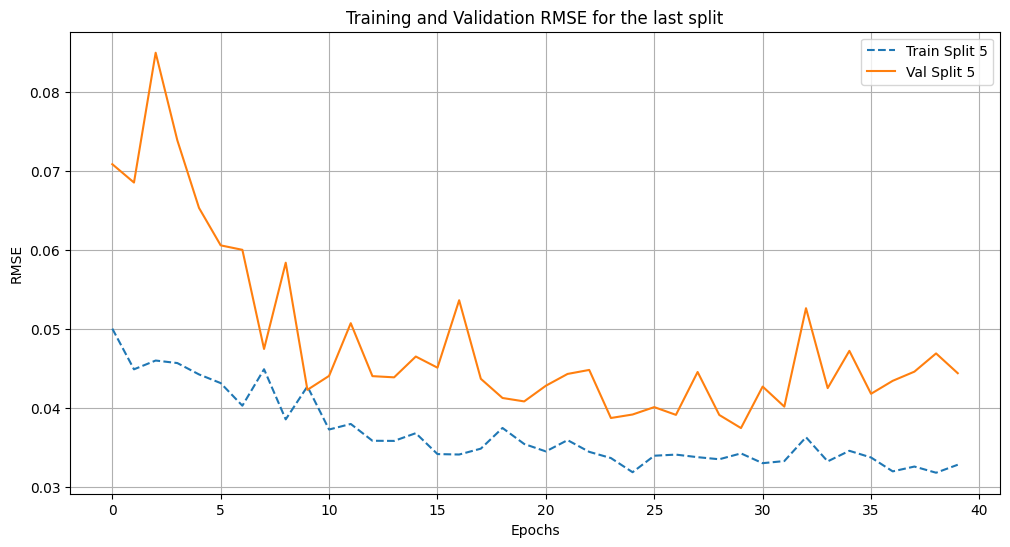

In [35]:
cross_validation(lstm_model, 5,40,32)

The validation curve is closely aligning with the training curve, indicating convergence. However, further tuning of parameters is required to achieve better results.

7/7 [==============================] - 2s 9ms/step


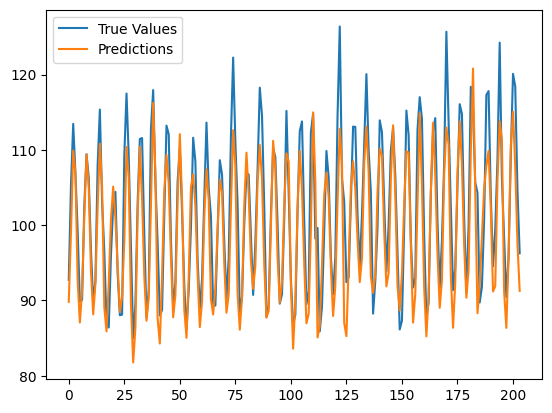

Mean Absolute Error (MAE): 4.138767473108628
Root mean sqared error(RMSE): 5.300945208771554


In [36]:
y_pred_rescaled , y_test_rescaled = predict_model(lstm_model)
plot_forecasts(y_test_rescaled,y_pred_rescaled )
# Calculate error metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = root_mean_squared_error(y_test_rescaled, y_pred_rescaled)

print("Mean Absolute Error (MAE):", mae)
print("Root mean sqared error(RMSE):", rmse)

##### Finding the Best Parameters for the Stacked LSTM Model

In [ ]:
# Objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be tuned
    units = trial.suggest_categorical('units', [80, 100, 150])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.3)
    epochs = 50  # Fix epochs to a reasonable value
    batch_size = 32  # Fix batch size

    # Build the model
    model = KerasRegressor(build_fn=LSTM_model, units=units, dropout_rate=dropout_rate, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Callbacks for early stopping and learning rate reduction
    callbacks = [
        EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3)
    ]
    
    # Define TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # Scoring Function for RMSE
    def neg_rmse(y_true, y_pred):
        return -np.sqrt(mean_squared_error(y_true, y_pred))

    scoring = make_scorer(neg_rmse, greater_is_better=False)

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring=scoring, fit_params={'callbacks': callbacks})
    
    # Return the mean score (negative RMSE) from cross-validation
    return np.mean(scores)

# Create an Optuna study
study = optuna.create_study(direction='minimize')  # Minimize RMSE (negative value)
study.optimize(objective, n_trials=15)  # Optimize for 15 trials

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

[I 2024-11-21 12:59:45,805] A new study created in memory with name: no-name-c7549749-f1be-45b9-9982-ed741f260543
[I 2024-11-21 13:00:49,245] Trial 0 finished with value: 0.04039752327220484 and parameters: {'units': 80, 'dropout_rate': 0.21820569649454363}. Best is trial 0 with value: 0.04039752327220484.
[I 2024-11-21 13:01:50,145] Trial 1 finished with value: 0.04057467641153911 and parameters: {'units': 80, 'dropout_rate': 0.20797547275927902}. Best is trial 0 with value: 0.04039752327220484.
[I 2024-11-21 13:03:47,560] Trial 2 finished with value: 0.039606967366947056 and parameters: {'units': 100, 'dropout_rate': 0.24106796725412616}. Best is trial 2 with value: 0.039606967366947056.
[I 2024-11-21 13:04:52,706] Trial 3 finished with value: 0.043221755724324816 and parameters: {'units': 80, 'dropout_rate': 0.2015113217662527}. Best is trial 2 with value: 0.039606967366947056.
[I 2024-11-21 13:06:24,794] Trial 4 finished with value: 0.04139909217624819 and parameters: {'units': 100

Best Hyperparameters:  {'units': 100, 'dropout_rate': 0.24106796725412616}
Best RMSE:  0.039606967366947056


In [45]:
# Extract the best hyperparameters from the Optuna study
best_params = study.best_params  # Get the best parameters as a dictionary

# Access individual hyperparameters
units = best_params['units']
dropout_rate = best_params['dropout_rate']
epochs = 50  # Fixed value as defined earlier
batch_size = 32  # Fixed value as defined earlier

# Print the best parameters
print("Best parameters from Optuna study:", best_params)
print((units, dropout_rate, epochs, batch_size))

Best parameters from Optuna study: {'units': 100, 'dropout_rate': 0.24106796725412616}
(100, 0.24106796725412616, 50, 32)


Split 1:
Epoch 1/50
8/8 [==============================] - 5s 224ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1353
Epoch 2/50
8/8 [==============================] - 1s 122ms/step - loss: 5.0904e-04 - root_mean_squared_error: 0.0226 - val_loss: 8.2666e-04 - val_root_mean_squared_error: 0.0288
Epoch 3/50
8/8 [==============================] - 1s 117ms/step - loss: 2.3886e-04 - root_mean_squared_error: 0.0155 - val_loss: 8.9536e-04 - val_root_mean_squared_error: 0.0299
Epoch 4/50
8/8 [==============================] - 1s 117ms/step - loss: 1.2284e-04 - root_mean_squared_error: 0.0111 - val_loss: 9.7481e-04 - val_root_mean_squared_error: 0.0312
Epoch 5/50
8/8 [==============================] - 1s 119ms/step - loss: 9.3841e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.0959e-04 - val_root_mean_squared_error: 0.0302
Epoch 6/50
8/8 [==============================] - 1s 117ms/step - loss: 6.3587e-05 - root_mean_squared_error:

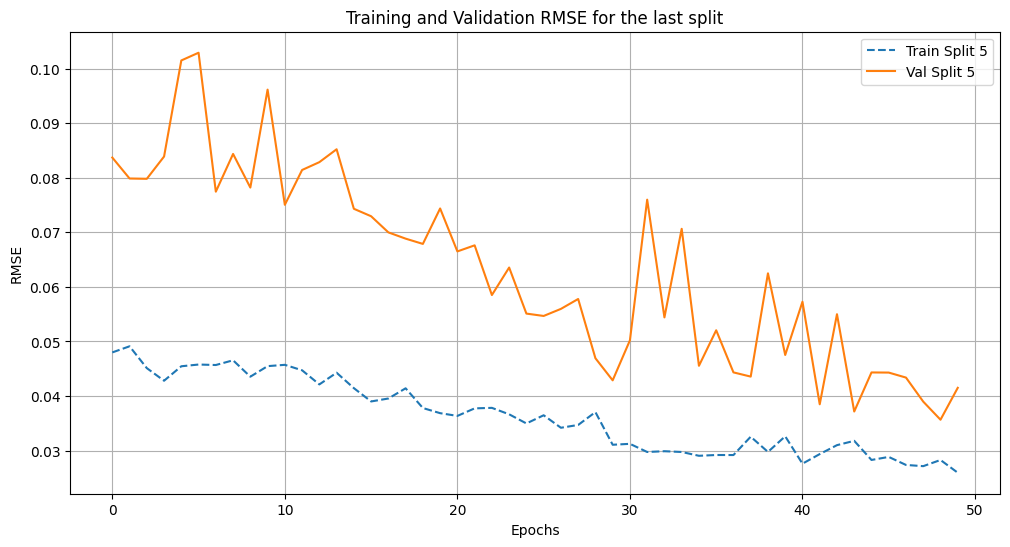

7/7 [==============================] - 0s 17ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427
Test Loss: [0.0018199319019913673, 0.0426606610417366]


In [46]:
# Build the LSTM model
opt_lstm_model =  LSTM_model( units=units, dropout_rate=dropout_rate)
cross_validation(opt_lstm_model, 3, epochs, batch_size)
loss = opt_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")


The curve shows that both the training and validation data curves remain below the training curve and converge smoothly, suggesting effective learning from the data.

7/7 [==============================] - 1s 14ms/step


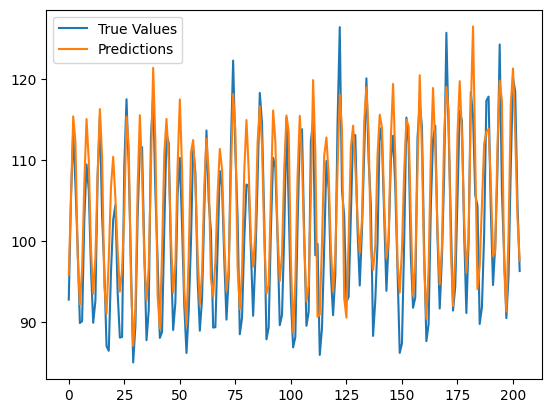

Mean Absolute Error (MAE): 4.362974486227595
Root mean sqared error(RMSE): 5.249119635589107


In [47]:
y_pred_rescaled , y_test_rescaled = predict_model(opt_lstm_model)
plot_forecasts(y_test_rescaled,y_pred_rescaled )
# Calculate error metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = root_mean_squared_error(y_test_rescaled, y_pred_rescaled)

print("Mean Absolute Error (MAE):", mae)
print("Root mean sqared error(RMSE):", rmse)

The LSTM with optimal hyperparameters yields better results and lower metrics, indicating that the new hyperparameters have enhanced the model's accuracy.

#### 2- CNN_LSTM Model

The CNN_LSTM model combines the strengths of LSTM networks for capturing temporal dependencies and Convolutional Neural Networks (CNN) for extracting spatial features, making it highly effective for tasks involving both sequential and spatial data. 

In [55]:
def CNN_LSTM_model(input_shape):
    """
    Create and configure a CNN-LSTM model for time series prediction.
    :param input_shape: Shape of the input data (time_steps, features)
    :return: The configured CNN-LSTM model (keras.Sequential)
    """
    model = Sequential()

    # Add a 1D convolutional layer with 64 filters, kernel size 3, and activation function
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # Add a max pooling layer to reduce the dimensionality of the output
    model.add(MaxPooling1D(pool_size=2))
    
    # Add another convolutional layer with 128 filters and kernel size 3
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    
    # Add another max pooling layer
    model.add(MaxPooling1D(pool_size=2))

    # Add LSTM layer with 100 units and return_sequences=True for multiple LSTM layers
    model.add(LSTM(units=100, return_sequences=False))

    # Add a Dropout layer for regularization
    model.add(Dropout(0.24))

    # Add a dense output layer with 1 unit (for regression tasks)
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


Split 1:
Epoch 1/40
8/8 [==============================] - 2s 71ms/step - loss: 0.0032 - val_loss: 0.0421
Epoch 2/40
8/8 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0203
Epoch 3/40
8/8 [==============================] - 0s 16ms/step - loss: 6.4865e-04 - val_loss: 0.0146
Epoch 4/40
8/8 [==============================] - 0s 17ms/step - loss: 1.8290e-04 - val_loss: 0.0010
Epoch 5/40
8/8 [==============================] - 0s 17ms/step - loss: 6.9558e-05 - val_loss: 0.0016
Epoch 6/40
8/8 [==============================] - 0s 17ms/step - loss: 5.4954e-05 - val_loss: 0.0010
Epoch 7/40
8/8 [==============================] - 0s 19ms/step - loss: 4.4755e-05 - val_loss: 0.0012
Epoch 8/40
8/8 [==============================] - 0s 19ms/step - loss: 3.7861e-05 - val_loss: 0.0011
Epoch 9/40
8/8 [==============================] - 0s 19ms/step - loss: 3.6352e-05 - val_loss: 0.0011
Epoch 10/40
8/8 [==============================] - 0s 18ms/step - loss: 4.6363e-05 - val_l

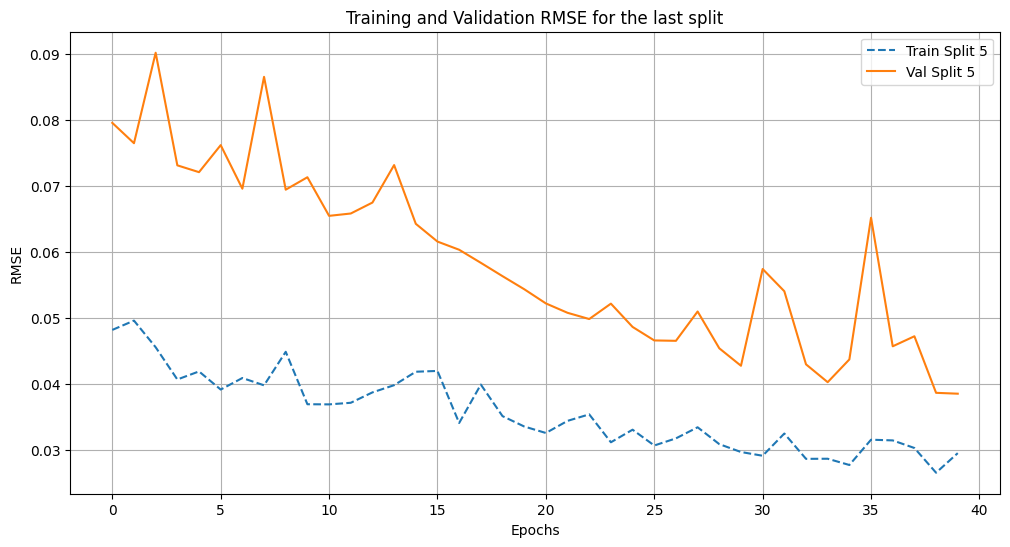

In [56]:
cnn_lstm_model = CNN_LSTM_model((X_train.shape[1], X_train.shape[2]))
cross_validation(cnn_lstm_model, 3,40,32)



The RMSE curve of the CNN-LSTM model converges with the training curve and does so more rapidly than the Stacked LSTM, indicating strong generalization capabilities.


In [57]:
loss = cnn_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")

7/7 [==============================] - 0s 3ms/step - loss: 0.0016
Test Loss: 0.0015941214514896274


7/7 [==============================] - 0s 3ms/step


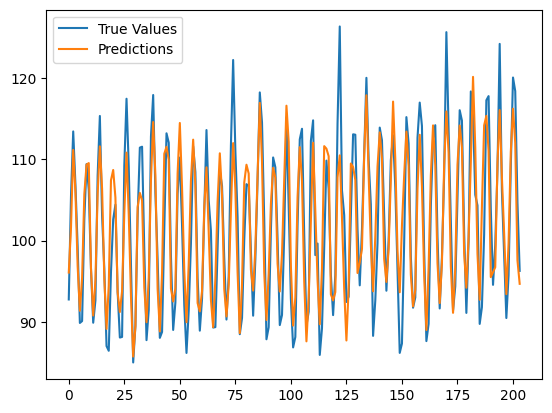

Mean Absolute Error (MAE): 3.952142196595435
Root mean sqared error(RMSE): 4.912694334424785


In [58]:
y_pred_rescaled , y_test_rescaled = predict_model(cnn_lstm_model)
plot_forecasts(y_test_rescaled,y_pred_rescaled )
# Calculate error metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = root_mean_squared_error(y_test_rescaled, y_pred_rescaled)

print("Mean Absolute Error (MAE):", mae)
print("Root mean sqared error(RMSE):", rmse)

Based on the performances of each model, the CNN-LSTM model demonstrates a strong balance between training and generalization capabilities, making it our chosen model for real-time forecasting.
